In [2]:
import os
import cv2
import librosa
import skimage.io
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

import imageio.core.util

def ignore_warnings(*args, **kwargs):
    pass

imageio.core.util._precision_warn = ignore_warnings

/home/splinter/.local/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/splinter/.local/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [3]:
DATA_FOLDER = "data/"
OUT = "samples/"
DATASET = "dataset.npy"
LABELS = ["cough", "not"]

#### Audio functions

In [16]:
sample_rate = 44000
duration = 0.5 #seconds
hop_length = 347*duration
n_mels = 128
fmin = 20
fmax = sample_rate//2
n_fft = n_mels*20

sample_size = int(sample_rate*duration)
silent_thresh = 0.0005

def envelope(signal, rate, thresh):
    mask = []
    y = pd.Series(signal).apply(np.abs)
    # Create aggregated mean
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for m in y_mean:
        mask.append(m > thresh)

    return mask

def load_audio(path):
    signal, rate = librosa.load(path, sr=sample_rate)
    mask = envelope(signal, rate, silent_thresh)
    signal = signal[mask]
    
    return signal

def melspectrogram(signal):
    spectro = librosa.feature.melspectrogram(
        signal,
        sr=sample_rate,
        n_mels=n_mels,
        n_fft=n_fft
    )
    spectro = librosa.power_to_db(spectro)
    spectro = spectro.astype(np.float32)
    return spectro

def minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def plot_spectro(spectro):
    librosa.display.specshow(
        spectro, 
        x_axis='time', 
        y_axis='mel', 
        sr=sample_rate, 
        hop_length=hop_length,                   
        fmin=fmin, 
        fmax=fmax    
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title("Log-frequency power spectrogram")
    plt.show()

def audio_to_image(audio, out):
    signal = load_audio(audio)
    mels = melspectrogram(signal)
    skimage.io.imsave(out, mels)

def process(audio, out):
    signal = load_audio(audio)
    
    current = 0
    end = False
    count = 0
    
    if len(signal) < sample_size:
        return

    while not end:
        if current+sample_size > len(signal):
            sample = signal[len(signal)-sample_size:]
            end = True
        else:
            sample = signal[current:current+sample_size]
            current += sample_size
        
        mels = melspectrogram(sample)
        skimage.io.imsave(out+str(count)+".png", mels, check_contrast=False)
        count += 1

### Convert dataset to log mel spectrogram

In [17]:
for l in LABELS:
    display(Markdown("**Processing:** *"+l+"*"))
    count = 0
    for audio in tqdm(os.listdir(DATA_FOLDER+l)):
        if os.path.splitext(audio)[-1] != ".wav":
            continue
        process(DATA_FOLDER+l+"/"+audio, OUT+l+"/"+str(count)+"-")
        count += 1

**Processing:** *cough*

100%|██████████| 36/36 [03:22<00:00,  5.64s/it]


**Processing:** *not*

100%|██████████| 2000/2000 [10:40<00:00,  3.12it/s]


In [4]:
DATA_SIZE = len(os.listdir(OUT+"cough/"))
display(Markdown("A total of **"+str(DATA_SIZE)+"** samples"))

A total of **5195** samples

### Save images with labels into numpy file

In [12]:
data = [[], []]
for i, label in enumerate(LABELS):
    samples = os.listdir(OUT+label)
    np.random.shuffle(samples)
    samples = samples[:DATA_SIZE]
    display(Markdown("**Processing:** *"+label+"*"))
    for image in tqdm(samples):
        img = cv2.imread(OUT+label+"/"+image)
        data[0].append(img)
        data[1].append(i)
    
np.save(DATASET, data)

**Processing:** *cough*

100%|██████████| 5195/5195 [00:00<00:00, 9053.36it/s]


**Processing:** *not*

100%|██████████| 5195/5195 [00:21<00:00, 240.84it/s]


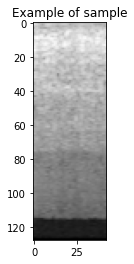

In [15]:
plt.title("Example of sample")
eg = plt.imshow(data[0][0])

In [84]:
display(Markdown("Sample has a **shape** of: *"+str(data[0][0].shape)+"*"))

Sample has a **shape** of: *(128, 43, 3)*